# Red Queen Observation

## Imports

In [1]:
import sys
import os
import os.path
import io
import csv
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import gamma
from scipy import integrate
import seaborn as sns
import numpy.random as nprand
from scipy.stats import gamma

## Read file

In [2]:
def readfiles(pathtofile, file_name, ext_name,withoutneutral,withoutnan,minq,minfert,logfert,line_to_begin):
    data_file = pathtofile+file_name+"."+ext_name
    data = dict()
    params = []
    nbline=1
    with io.open(data_file,'r') as f:
        reader = csv.reader(f)
        firstline = True
        for line in reader:
            lin = line[0].split()
            if not firstline:
                if nbline>=line_to_begin:
                    for j in range(len(lin)):
                        if ext_name == "allele":
                            if float(lin[5])>minq and float(lin[6])>minfert:
                                if withoutneutral==1 and float(lin[1]) != -3 :
                                    if withoutnan == 0:
                                        if logfert==True and (j==6 or j==9):
                                            data[params[j]].append(np.log(float(lin[j])))
                                        else:
                                            data[params[j]].append(float(lin[j]))
                                    elif withoutnan ==1 :
                                        if lin[5]!="-nan" and lin[6]!="-nan":
                                            if logfert==True and (j==6 or j==9):
                                                data[params[j]].append(np.log(float(lin[j])))
                                            else:
                                                data[params[j]].append(float(lin[j])) 
                                elif withoutneutral==0:
                                    if withoutnan == 0:
                                        if logfert==True and (j==6 or j==9):
                                            data[params[j]].append(np.log(float(lin[j])))
                                        else:
                                            data[params[j]].append(float(lin[j]))
                                    elif withoutnan ==1 :
                                        if lin[5]!="-nan" and lin[6]!="-nan":
                                            if logfert==True and (j==6 or j==9):
                                                data[params[j]].append(np.log(float(lin[j])))
                                            else:
                                                data[params[j]].append(float(lin[j]))
                        elif ext_name == "trace" and logfert==True and (j==6 or j==14):
                            data[params[j]].append(np.log(float(lin[j])))
                        else :
                            data[params[j]].append(float(lin[j]))
                nbline=nbline+1
            else:
                for j in lin:
                    data[j]=[]
                    params.append(j)
                firstline = False
                nbline=nbline+1
    return (data)

### Colorblind palette

In [3]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

## Functions for plot

In [4]:
def graph_per_allele(target_folder_path, file_name, ext_name, x_axis_param, y_axis_param,withoutneutral,withoutnan,minq,minfert,logfert,line_to_begin):
    data_all = readfiles(target_folder_path, file_name, 'allele',withoutneutral,withoutnan,minq,minfert,logfert,line_to_begin)
    data_trace = readfiles(target_folder_path, file_name, 'trace',withoutneutral,withoutnan,minq,minfert,logfert,line_to_begin)
    x_per_allele=dict()
    y_per_allele=dict()
    for i in range(len(data_all["Generation_number"])):
        cle = data_all['Allele_number'][i]
        if ((str(cle) in x_per_allele) == False and cle!=-3):
            x_per_allele[str(cle)]=[]
            x_per_allele[str(cle)].append(data_all[x_axis_param][i])
            y_per_allele[str(cle)]=[]
            if y_axis_param=="selection":
                sel_coef=np.log(data_all['fertility_analytic'][i])-np.log(data_trace['fertility_analytic'][int(data_all["Generation_number"][i]/100)])
                y_per_allele[str(cle)].append(sel_coef)
            else:
                y_per_allele[str(cle)].append(data_all[y_axis_param][i])
        elif ((str(cle) in x_per_allele) == True and cle!=-3):
            x_per_allele[str(cle)].append(data_all[x_axis_param][i])
            if y_axis_param=="selection":
                sel_coef=np.log(data_all['fertility_analytic'][i])-np.log(data_trace['fertility_analytic'][int(data_all["Generation_number"][i]/100)])
                y_per_allele[str(cle)].append(sel_coef)
            else:
                y_per_allele[str(cle)].append(data_all[y_axis_param][i])
    return(x_per_allele,y_per_allele)

In [5]:
def plot_regim_per_allele(target_folder_path, file_name, ext_name, x_param, y_params, withoutneutral, withoutnan,minq,minfert,logfert,line_to_begin, allelenbmin, allelenbmax,boldallel,xmin,xmax,x_letter,ymin,ymax):
    index_line=1
    legend_list=["Frequency of\n PRDM9 alleles ("r"$f_i$)","Proportion of\n active sites ("r"$\theta_i$)","Mean affinity\n of active sites\n per allele ("r"$\bar y_i$)","Symmetrical binding\n probability analytic ("r"$q_i$)","Fertility of PRDM9\n alleles analytic ("r"$w_i$)"]
    lettres=["A","B","C","D","E","F","G","H","I","J","K","L"]
    figure=plt.figure(figsize=(8,4))
    figure.patch.set_facecolor('white')
    figure.patch.set_alpha(0)
    for i in y_params:
        max_y=0
        plt.subplot(len(y_params),1,index_line) 
        (X,Y)=graph_per_allele(target_folder_path, file_name, ext_name, x_param, i, withoutneutral,withoutnan,minq,minfert,logfert,line_to_begin)
        index_color=0 ###############
        for j in range(allelenbmax-allelenbmin):
            allele_nb=allelenbmin+j
            nameallelelist=[str(allele_nb),'.0']
            nameallele=''.join(nameallelelist)
            if X.get(nameallele, 0)!=0:
                if(float(nameallele)==boldallel):
                    plt.plot(X[nameallele], Y[nameallele],linewidth=3,color=CB_color_cycle[index_color])# linewidth=6 ############
                else:
                    plt.plot(X[nameallele], Y[nameallele],color=CB_color_cycle[index_color])
                if(max_y<max(Y[nameallele])):
                    max_y=max(Y[nameallele])
                index_color+=1###############
                index_color=index_color%9################
        plt.ylabel(legend_list[index_line-1],fontsize=11)
        plt.text(x=x_letter,y=max_y,s=lettres[index_line-1],fontweight='bold',fontsize=16)
        if index_line==len(y_params):
            plt.xlabel("Number of generations",fontsize=12)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        if i=="selection":
            plt.axhline(y=0, color='black')
        plt.xlim(xmin,xmax)
        plt.ylim(ymin[index_line-1],ymax[index_line-1])
        plt.grid()#############
        index_line+=1

In [6]:
path_to_file_init = "../../../analyses/"

## With only 1 meiosis

### Parameters for the plot

In [7]:
u="6e-5"
aff="2e-1"
nbmei="1"
path_to_file_to_plot = "scaling_empiric/scaling_empiric_nbmei_"+nbmei+"/scaling_bidim_u_aff_2/scaling_empiric_U_"+u+"/"
file_to_plot = "Run_aff_"+aff
ext_of_file = "allele"
x_parameter = "Generation_number"
y_parameters = ["Frequency","Activity"]
withoutneutral = 0
withoutnan = 0
minq = 0
minfert = 0
logfert = 0
line_to_begin = 413
allelenbmin = 0
allelenbmax = 100000
boldallel = 1232
xmin = 10000
xmax = 50000
x_letter = 2000
ymin=[0,0.08]
ymax=[1.05,1.05]

### Graphic

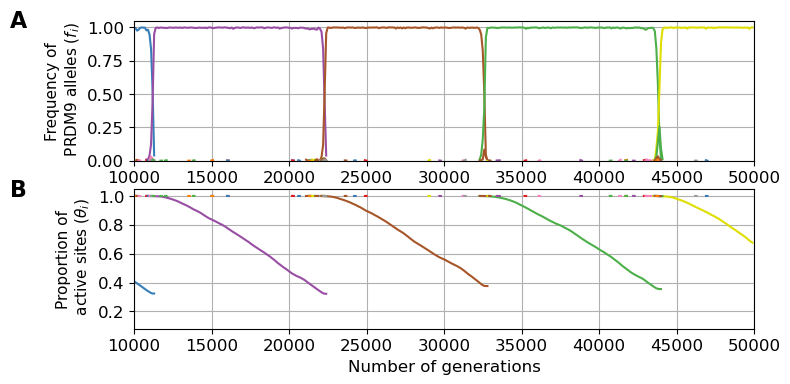

In [9]:
fig1=plot_regim_per_allele(path_to_file_init+path_to_file_to_plot, file_to_plot, ext_of_file, x_parameter,y_parameters,withoutneutral, withoutnan,minq,minfert,logfert,line_to_begin, allelenbmin, allelenbmax,boldallel,xmin,xmax,x_letter,ymin,ymax)
plt.savefig('Fig7.png', dpi=200, bbox_inches='tight')

**Caption : An example of a PRDM9 dynamic with only one meiosis allowed per individual (nmei = 1,
u = 6 × 10−5 and  ̄y = 0.2).** In all the graphs, each color correspond to a different allele. If a color appears
several generation after the death of an allele of the same color, it is considered as a complete different
allele.This graph represents the evolution along time of the frequency of each PRDM9 allele (A) and their
proportion of active sites (B). This corresponds to an eviction regime.

## With up to 5 meiosis

### Parameters for the plot

In [20]:
u="6e-5"
aff="2e-1"
nbmei="5"
path_to_file_to_plot = "scaling_empiric/scaling_empiric_nbmei_"+nbmei+"/scaling_bidim_u_aff_2/scaling_empiric_U_"+u+"/"
file_to_plot = "Run_aff_"+aff
ext_of_file = "allele"
x_parameter = "Generation_number"
y_parameters = ["Frequency","Activity"]
withoutneutral = 0
withoutnan = 0
minq = 0
minfert = 0
logfert = 0
line_to_begin = 413
allelenbmin = 0
allelenbmax = 100000
boldallel = 1232
xmin = 10000
xmax = 50000
x_letter = 2000
ymin=[0,0.08]
ymax=[1.05,1.05]

### Graphic

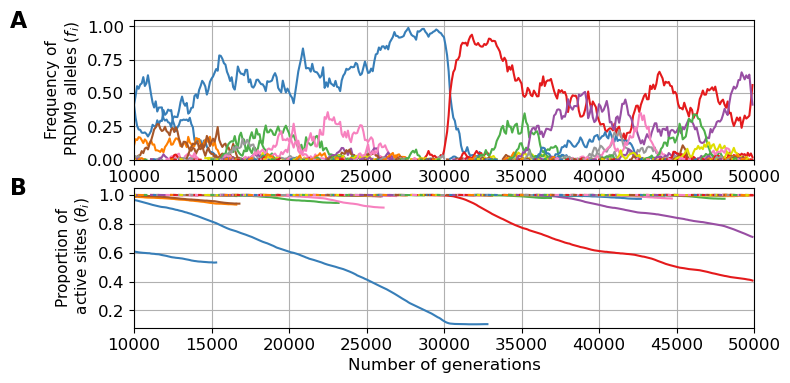

In [21]:
fig2=plot_regim_per_allele(path_to_file_init+path_to_file_to_plot, file_to_plot, ext_of_file, x_parameter,y_parameters,withoutneutral, withoutnan,minq,minfert,logfert,line_to_begin, allelenbmin, allelenbmax,boldallel,xmin,xmax,x_letter,ymin,ymax)
plt.savefig('RQ_emp_5_mei.png', dpi=200, bbox_inches='tight')

**Caption : An example of a PRDM9 dynamic with five meiosis per individual allowing up to 80%
decrease in number of gametes (nmei = 5, u = 6 × 10−5 and  ̄y = 0.2).** In all the graphs, each color
correspond to a different allele. If a color appears several generation after the death of an allele of the same
color, it is considered as a complete different allele.This graph represents the evolution along time of the
frequency of each PRDM9 allele (A) and their proportion of active sites (B). This better corresponds to the
polymorphic regime observed empirically.